# Abstract gates


## Built-in standard gates
Besides constant gates, such as Hadamard, or CNOT, pyAQASM offers the possibilty to manipulate and declare abstract gates. pyAQASM natively supports 4 abstract gates: `RX`, `RY`, `RZ`, `PH`). You can see a definition of these gates [here](tutorials/lang/available_gates.ipynb).

In the following cell, you can see the difference between the abstract gate `RX` and its actual implementation. While an `AbstractGate` gate cannot be compiled to a `Circuit` object, a `ParamGate` can be compiled and simulated.

In [5]:
from qat.lang.AQASM import Program, RX, Y, AbstractGate
import numpy as np

print(type(RX))
print(type(RX(np.pi)))

<class 'qat.lang.AQASM.gates.AbstractGate'>
<class 'qat.lang.AQASM.gates.ParamGate'>


Even if it's not possible to compile it, we can still apply the `AbstractGate` to a `Program`. Remember: the `Program` object is the quantum circuit representation **BEFORE** compilation.

In [40]:
pr = Program()
qr = pr.qalloc()
pr.apply(RX, qr)

As we said, compilation will fail.

In [43]:
try:
    cr = pr.to_circ()
except:
    print("Circuit generation failed")

Circuit generation failed


There are two ways to circumvent this problem. The first one is to trivially pass the `AbstractGate` all the parameters it requires in order to make it a proper `ParamGate`. The `Program` obtained can be both compiled and simulated.

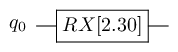

In [44]:
pr2 = Program()
qr2 = pr2.qalloc()
pr2.apply(RX(2.3), qr2)

cr2 = pr2.to_circ()
%qatdisplay cr2

Another interesting alternative exploits variables.

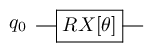

In [45]:
pr3 = Program()
qr3 = pr3.qalloc()
theta = pr3.new_var(float, "\\theta")
pr3.apply(RX(theta),qr)

cr3 = pr3.to_circ()
%qatdisplay cr3

Even if we are able to compile the `Program` object, we still cannot simulate it. To proceed to the simulation, we have to give the variable a proper value, a process known as binding.

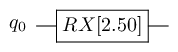

In [46]:
new_circuit = cr3.bind_variables({"\\theta": theta_val})
%qatdisplay new_circuit

The variable creation and binding comes handy when we want to simulate the same circuit many times with different parameters.

******************************
Theta is 0.5


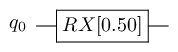

State |0> with amplitude (0.9689124217106447+0j)
State |1> with amplitude -0.24740395925452294j
******************************
Theta is 1.5


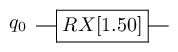

State |0> with amplitude (0.7316888688738209+0j)
State |1> with amplitude -0.6816387600233341j
******************************
Theta is 2.5


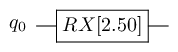

State |0> with amplitude (0.3153223623952687+0j)
State |1> with amplitude -0.9489846193555862j


In [48]:
from qat.qpus import PyLinalg
qpu = PyLinalg()

for theta_val in (.5, 1.5, 2.5):
    print("*" * 30)
    print(f"Theta is {theta_val}")
    new_circuit = cr3.bind_variables({"\\theta": theta_val})
    %qatdisplay new_circuit
    res = qpu.submit(new_circuit.to_job())
    for sample in res:
        print(f"State {sample.state} with amplitude {sample.amplitude}")

## Create new abstract gates

Apart from those already present in the language, new abstract gates can be defined. We will briefly see two ways to create an abstract gate.

In [50]:
prog = Program()
qreg = prog.qalloc(3)

Abstract gates do not require a particular matrix description: they are boxes with a name and a
signature (the list of parameters it accepts as input).

In [55]:
my_gate = AbstractGate("mygate", # The name of the gate
                       [float],  # Its signature: (here a single float)
                       arity=2)  # Its arity 
prog.apply(my_gate(0.3), qreg[0], qreg[1])
print(type(my_gate))

<class 'qat.lang.AQASM.gates.AbstractGate'>


Here we define a new abstract gate, a CNOT, through its matrix. The matrices lines and columns should be enumerated using the first qubit as most significant qubit. For instance, the matrix corresponding to a CNOT gate whose first argument is the control qubit will look like:
$$
\begin{bmatrix}1&0&0&0\\0&1&0&0\\0&0&0&1\\0&0&1&0\end{bmatrix}$$


In [57]:
My_CNOT = AbstractGate("MY\_CNOT", 
                       [], # no input parameter, as expected 
                       arity=2,
                       matrix_generator=lambda : np.array([[1,0,0,0],
                                                           [0,1,0,0],
                                                           [0,0,0,1],
                                                           [0,0,1,0]])
                      )
print(type(My_CNOT)) # Why it is still an abstract gate?
prog.apply(My_CNOT(), qreg[0], qreg[1])

<class 'qat.lang.AQASM.gates.AbstractGate'>


To answer the previous question, note the difference between these two lines.

In [58]:
print(type(My_CNOT))
print(type(My_CNOT()))

<class 'qat.lang.AQASM.gates.AbstractGate'>
<class 'qat.lang.AQASM.gates.ParamGate'>


We can treat abstract gates as any other standard gate.
Recall, for example, that any gate can be modified using the following gate operators:
- *dag()*: Creates  the dagger of the parent Gate
- *ctrl()*: Creates a controlled version of the parent Gate
- *conj()*: Creates the complex conjugate of the parent Gate
- *trans()*: Creates the transpose of the parent Gate.

In [59]:
prog.apply(My_CNOT().dag().ctrl(), qreg)

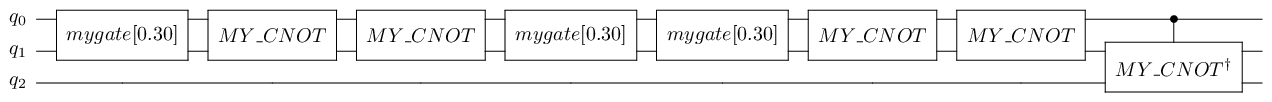

In [60]:
circ = prog.to_circ()
%qatdisplay circ

What if we want to associate a more complex function to an abstract gate? We will see later how to do it using `QRoutine`s.